### Sign detection and classification by point cloud.
    Applicable for LIDAR-like solutions.
    The plate (top of the sign) is highly reflective, whereas the pole is not.


Module import:

In [ ]:
from pathlib import Path

import numpy as np

import detectors as alg
import io_utils as io

Simulated data produced in Blender software and modified.
There are three scenarios with three plate shape types for in each:

#### Scenarios, location
 - No rotation, Objects\straight
 - Z axis rotation by 15$^o$, Objects\rot_z
 - X axis rotation by 15$^o$, Objects\rot_x

#### Plate shape types, file name
 - Square, square.ply
 - Deformed circle, circle.ply
 - Triangle, triangle.ply

All of above have lower sample count than in provided example and higher noise level.
Later is tuned in provided script.


Data path specification:

In [10]:
pole_path = Path(r"Objects\rot_z\pole.ply")
plate_path = Path(r"Objects\rot_z\triangle.ply")

min_ratio = 0.5 # Lower threshold is suggested for simulated data due to lower sample count

Data preview:

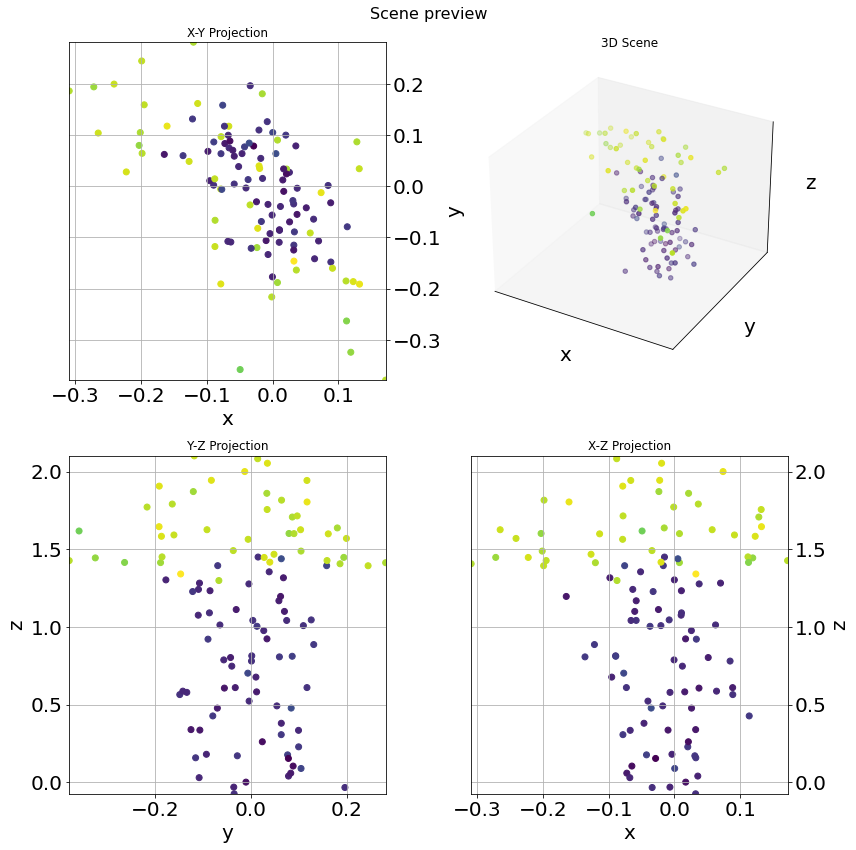

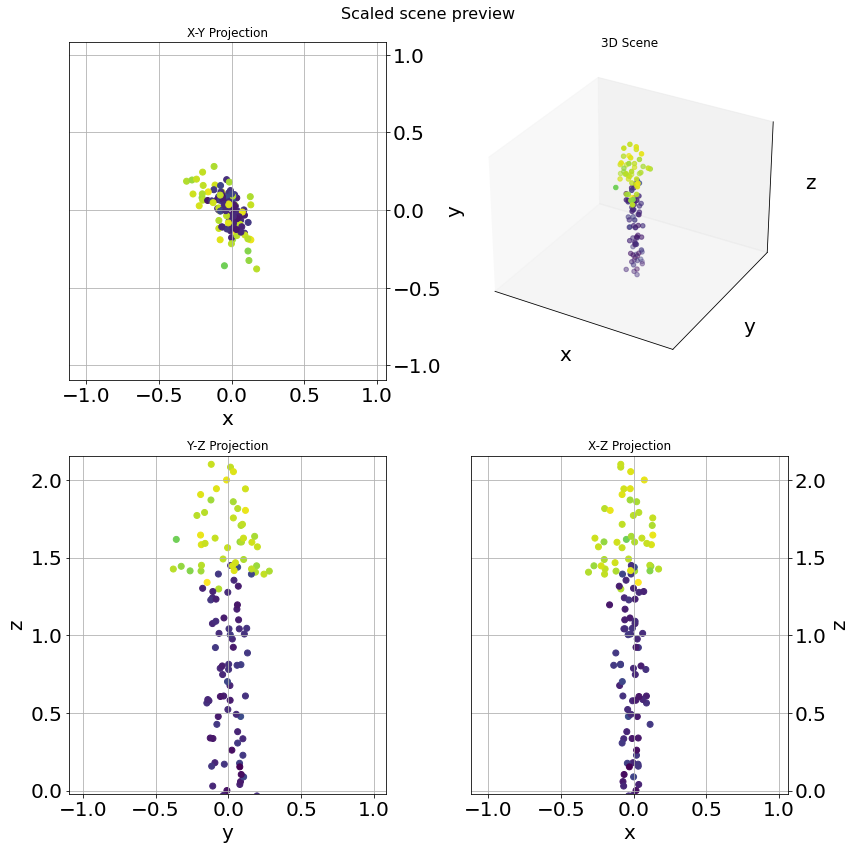

In [11]:
points = io.prep_scene(plate_path, pole_path, noise_level = 0.05)
scene = io.SceneViewer(points)  # Initialization of scene view
sign_detector = alg.BiModal()  # Initialization of bi modal detector

scene.show_cluster(points, False, title='Scene preview')
scene.show_cluster(points, True, title='Scaled scene preview')  # Cluster preview

Detection of Bi-Modal reflectivity density:

2 modes are found.


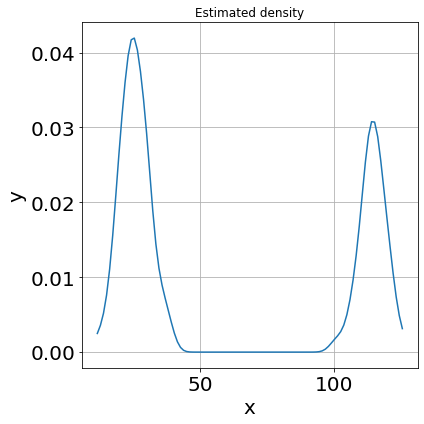

In [12]:
sign_detector.fit_kde(points[:, -1])
dens, dens_x = sign_detector.produce_density_arr(points[:, -1], 100) # Generation of smooth density function
mode_status = sign_detector.detect_modes(dens_x, dens) # Mode detection and threshold detection

io.plot_fun(dens, dens_x, title='Estimated density')

io.status_report(mode_status)  # Stops the execution if not a sign

Plate orientation detection:

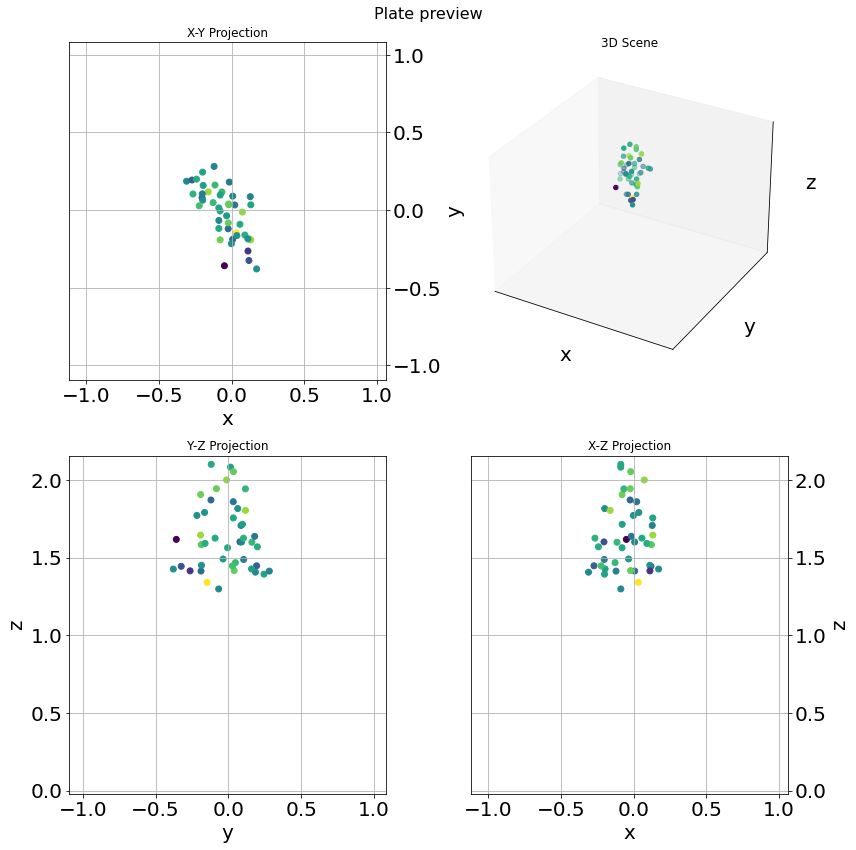

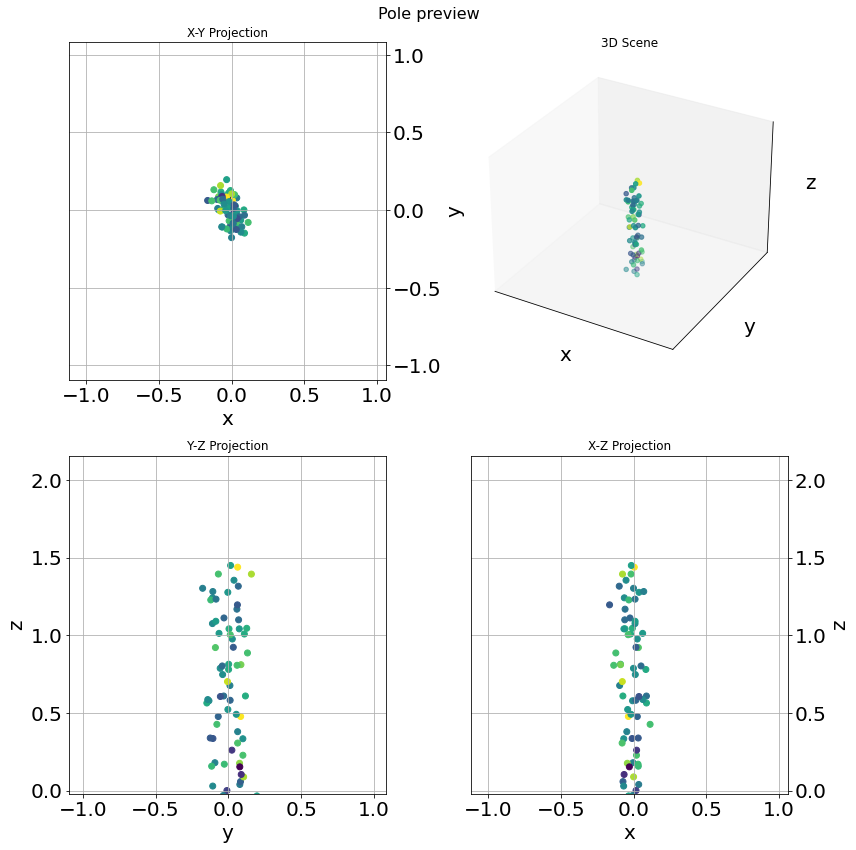

Excpected amount 25 is achived with threshold 0.05
Inliers 25/45


In [13]:
points_plate, points_pole = sign_detector.separate_by_thresh(points)  # Two sets of points - pole and plate

scene.show_cluster(points_plate, True, 'Plate preview')  # Plate preview
scene.show_cluster(points_pole, True, 'Pole preview')  # Pole preview

plate_plane = alg.Plate(min_ratio)  # At least 75% of points have to form a plane
plate_status = plate_plane.detect_plane_coefs(points_plate)  # Detect the 3D plane coefficients and normal

io.status_report(plate_status)  # Stops the execution if not a sign

Plate preview by inliers and outliers:

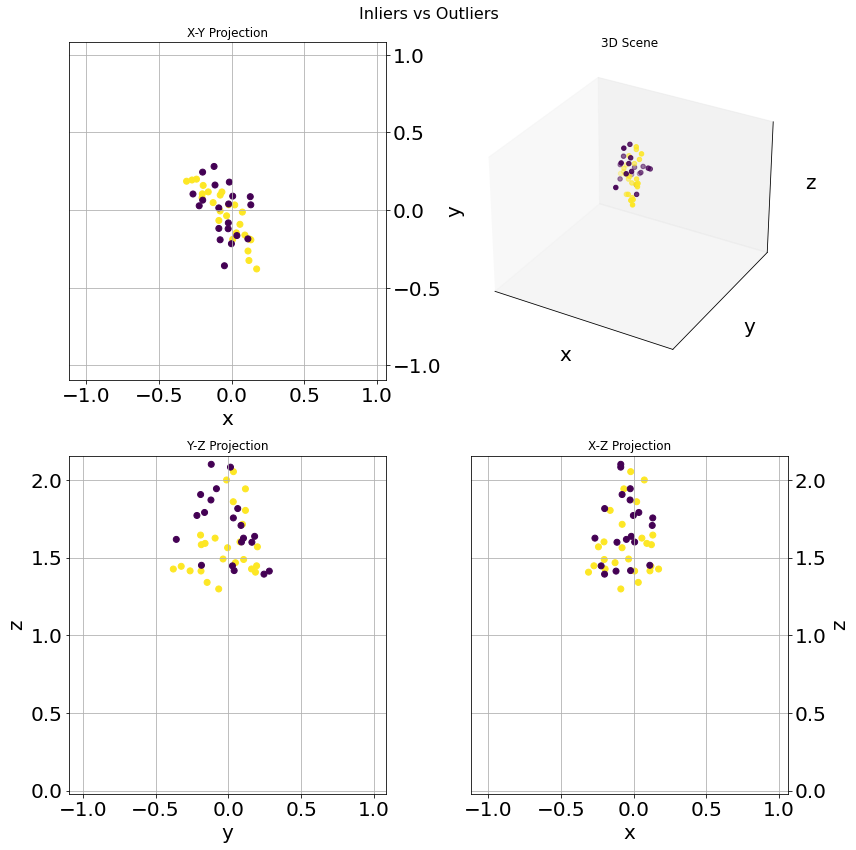

In [14]:
scene.show_cluster(np.concatenate((plate_plane.inliers, plate_plane.outliers), 0),
                   True, 'Inliers vs Outliers')  # Inliers and outliers preview

projected_points = plate_plane.project_to_plate(points_plate)  # Project plate points to plate, including outliers

Preview of points projection to plate plane:

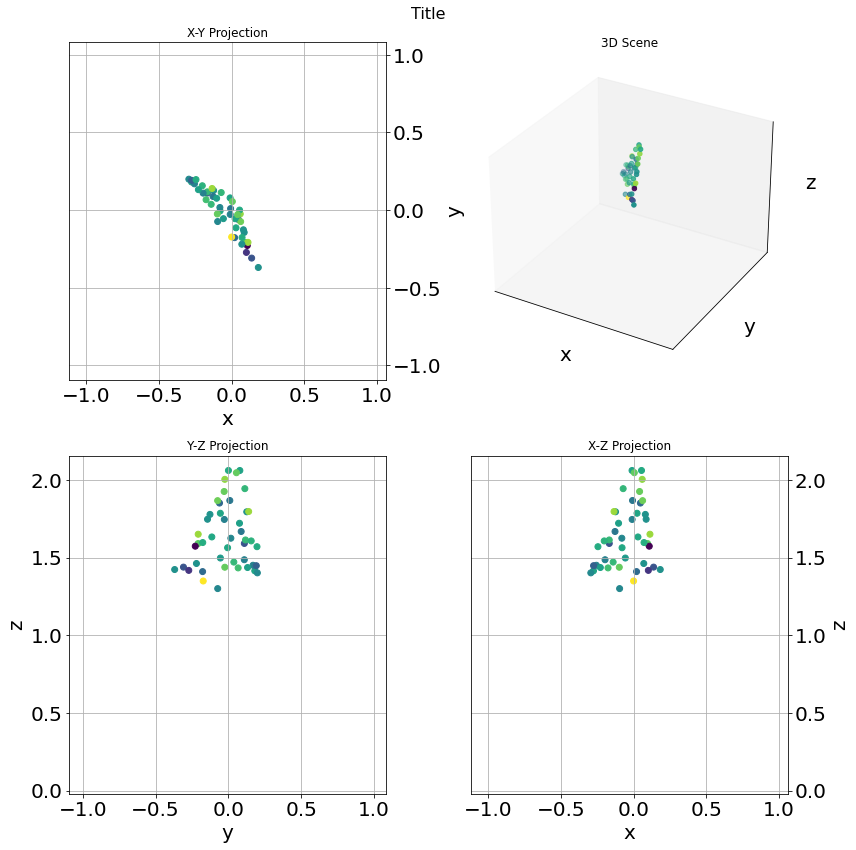

In [15]:
scene.show_cluster(projected_points, True)  # Preview the projected points

projected_points, img = plate_plane.rotate_plane(projected_points)  # Align plate plane with xy plane

Preview of points in image space:

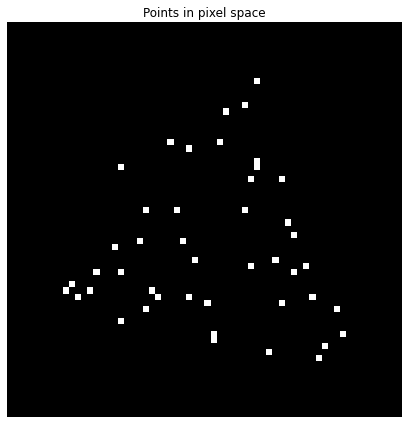

In [16]:
io.show_image(img, title='Points in pixel space')  # Preview the image

Shape detection:

The Triangle shaped sign is detected.


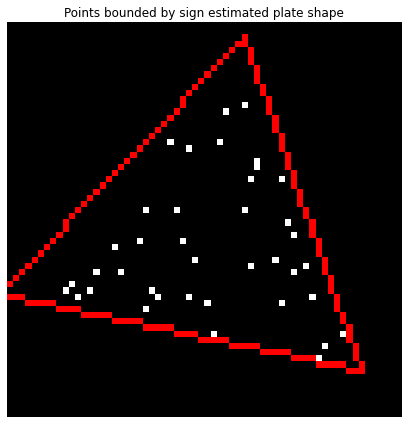

In [17]:
img = plate_plane.detect_shapes(img, True)  # Check what shape suits the most to plate
io.show_image(img, title='Points bounded by sign estimated plate shape')